In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc
import xgboost as xgb
from xgboost import XGBClassifier


# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [38]:
data = pd.read_csv('hk201819.csv')
data = data.dropna()
# print(data.describe())



x = data[['H1aA', 'H1aB', 'H1bA', 'H1bB', 'H1cA', 'H1cB',
          'H1dA', 'H1dB', 'H1eA', 'H1eB', 'H1fA', 'H1fB', 'H1gA', 'H1gB', 'H2a', 'H2b', 'H2c', 'H2d', 'H2e', 'H2f',
          'H2g', 'H2h', 'H2i', 'H2j']]
y = data[['sCPS']]

N = 4

In [23]:
pca_4 = PCA(n_components=4)

x = pca_4.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2023, train_size=0.8)

scaler_x_train = preprocessing.StandardScaler().fit(x_train)

x_train = scaler_x_train.transform(x_train)

scaler_x_test = preprocessing.StandardScaler().fit(x_test)

x_test = scaler_x_test.transform(x_test)

K-Nearest Neighbors Algorithm with GridSearchCV

In [24]:
model_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid={'n_neighbors': range(2, 50)}, cv=10).fit(x_train, y_train)
print(model_knn.best_params_)
print('KNN, Training set score:', round(model_knn.score(x_train, y_train) * 100, 4))
print('KNN, Test set score:', round(model_knn.score(x_test, y_test) * 100, 4))

{'n_neighbors': 37}
KNN, Training set score: 63.2724
KNN, Test set score: 62.0733


Random Forest Classifier with HyperOpt

In [25]:
def hyperopt_rf_score(params):
    clf = RandomForestClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_rf = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(2,400)),
    'max_features': hp.choice('max_features', range(2,10))
}

best = fmin(fn=hyperopt_rf_score, space=space_rf, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

nan                                                                             
{'criterion': 'entropy', 'max_depth': 267, 'max_features': 6}                   
0.5974425870309975                                                              
{'criterion': 'entropy', 'max_depth': 361, 'max_features': 2}                   
0.5928801173706814                                                              
{'criterion': 'entropy', 'max_depth': 89, 'max_features': 2}                    
nan                                                                             
{'criterion': 'gini', 'max_depth': 366, 'max_features': 6}                      
nan                                                                             
{'criterion': 'entropy', 'max_depth': 199, 'max_features': 8}                   
nan                                                                             
{'criterion': 'entropy', 'max_depth': 119, 'max_features': 8}                   
nan                         

In [26]:
params = space_eval(space_rf, best)
params

{'criterion': 'gini', 'max_depth': 101, 'max_features': 3}

In [27]:
model_random_forest = RandomForestClassifier(**params)
model_random_forest.fit(x_train, y_train)
model_random_forest.score(x_train, y_train)
print('Random Forest Classifier, Training set score:', round(model_random_forest.score(x_train, y_train) * 100, 4))
print('Random Forest Classifier, Test set score:', round(model_random_forest.score(x_test, y_test) * 100, 4))

Random Forest Classifier, Training set score: 96.8614
Random Forest Classifier, Test set score: 59.1474


AdaBoost Classifier

In [28]:
def hyperopt_ab_score(params):
    clf = AdaBoostClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_ab = {
    'n_estimators': hp.choice('n_estimators', range(50, 1000)),
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001)
}

best = fmin(fn=hyperopt_ab_score, space=space_ab, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.5815535186607812                                                              
{'learning_rate': 0.0446, 'n_estimators': 279}                                  
0.5812388986536219                                                              
{'learning_rate': 0.0378, 'n_estimators': 221}                                  
0.5803736085513278                                                              
{'learning_rate': 0.003, 'n_estimators': 890}                                   
0.5814355786993994                                                              
{'learning_rate': 0.0388, 'n_estimators': 826}                                  
0.5814749178024681                                                              
{'learning_rate': 0.0471, 'n_estimators': 683}                                  
0.5793510239150189                                                              
{'learning_rate': 0.0026000000000000003, 'n_estimators': 585}                   
0.5812782222871257          

In [29]:
params = space_eval(space_ab, best)
params

{'learning_rate': 0.0026000000000000003, 'n_estimators': 585}

In [30]:
model_ada_boost = AdaBoostClassifier(**params)
model_ada_boost.fit(x_train, y_train)
print('AdaBoost Classifier, Training set score:', round(model_ada_boost.score(x_train, y_train) * 100, 4))
print('AdaBoost Classifier, Test set score:', round(model_ada_boost.score(x_test, y_test) * 100, 4))

AdaBoost Classifier, Training set score: 57.9272
AdaBoost Classifier, Test set score: 58.6912


XGB Classifier with HyperOpt

In [31]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_xgb = {
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
    'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'exact'
}

best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6154969767829679                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.9400000000000001, 'eta': 0.32, 'eval_metric': 'auc', 'gamma': 0.785, 'learning_rate': 0.0034000000000000002, 'max_depth': 5, 'min_child_weight': 4.65, 'n_estimators': 822, 'objective': 'binary:logistic', 'subsample': 0.79, 'tree_method': 'exact'}
0.6211993058496921                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.91, 'eta': 0.41500000000000004, 'eval_metric': 'auc', 'gamma': 0.86, 'learning_rate': 0.0089, 'max_depth': 8, 'min_child_weight': 6.800000000000001, 'n_estimators': 794, 'objective': 'binary:logistic', 'subsample': 0.795, 'tree_method': 'exact'}
0.6169522451443357                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.86, 'eta': 0.17, 'eval_metric': 'auc', 'gamma': 0.665, 'learning_rate': 0.006200000000000001, 'max_depth': 8, 'min_child_weight': 1.

In [32]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.71,
 'eta': 0.16,
 'eval_metric': 'auc',
 'gamma': 0.9450000000000001,
 'learning_rate': 0.047900000000000005,
 'max_depth': 8,
 'min_child_weight': 5.2,
 'n_estimators': 651,
 'objective': 'binary:logistic',
 'subsample': 0.86,
 'tree_method': 'exact'}

In [33]:
model_xgb = XGBClassifier(**params)
model_xgb.fit(x_train, y_train)
print('XGB Classifier, Training set score:', round(model_xgb.score(x_train, y_train) * 100, 4))
print('XGB Classifier, Test set score:', round(model_xgb.score(x_test, y_test) * 100, 4))

XGB Classifier, Training set score: 75.41
XGB Classifier, Test set score: 61.9003


ROC Curve

In [34]:
def multi_models_roc(names, sampling_methods, colors, x_test, y_test, save=False, dpin=300):

        plt.figure(figsize=(10, 10), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            
            y_test_preds = method.predict(x_test)
            y_test_predprob = method.predict_proba(x_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)

            plt.plot(fpr, tpr, lw=2, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=20)
            plt.ylabel('True Positive Rate',fontsize=20)
            plt.title('ROC Curve',fontsize=25)
            plt.legend(loc='lower right',fontsize =16.6)

        if save:
            plt.savefig('multi_models_roc.png')

        return plt

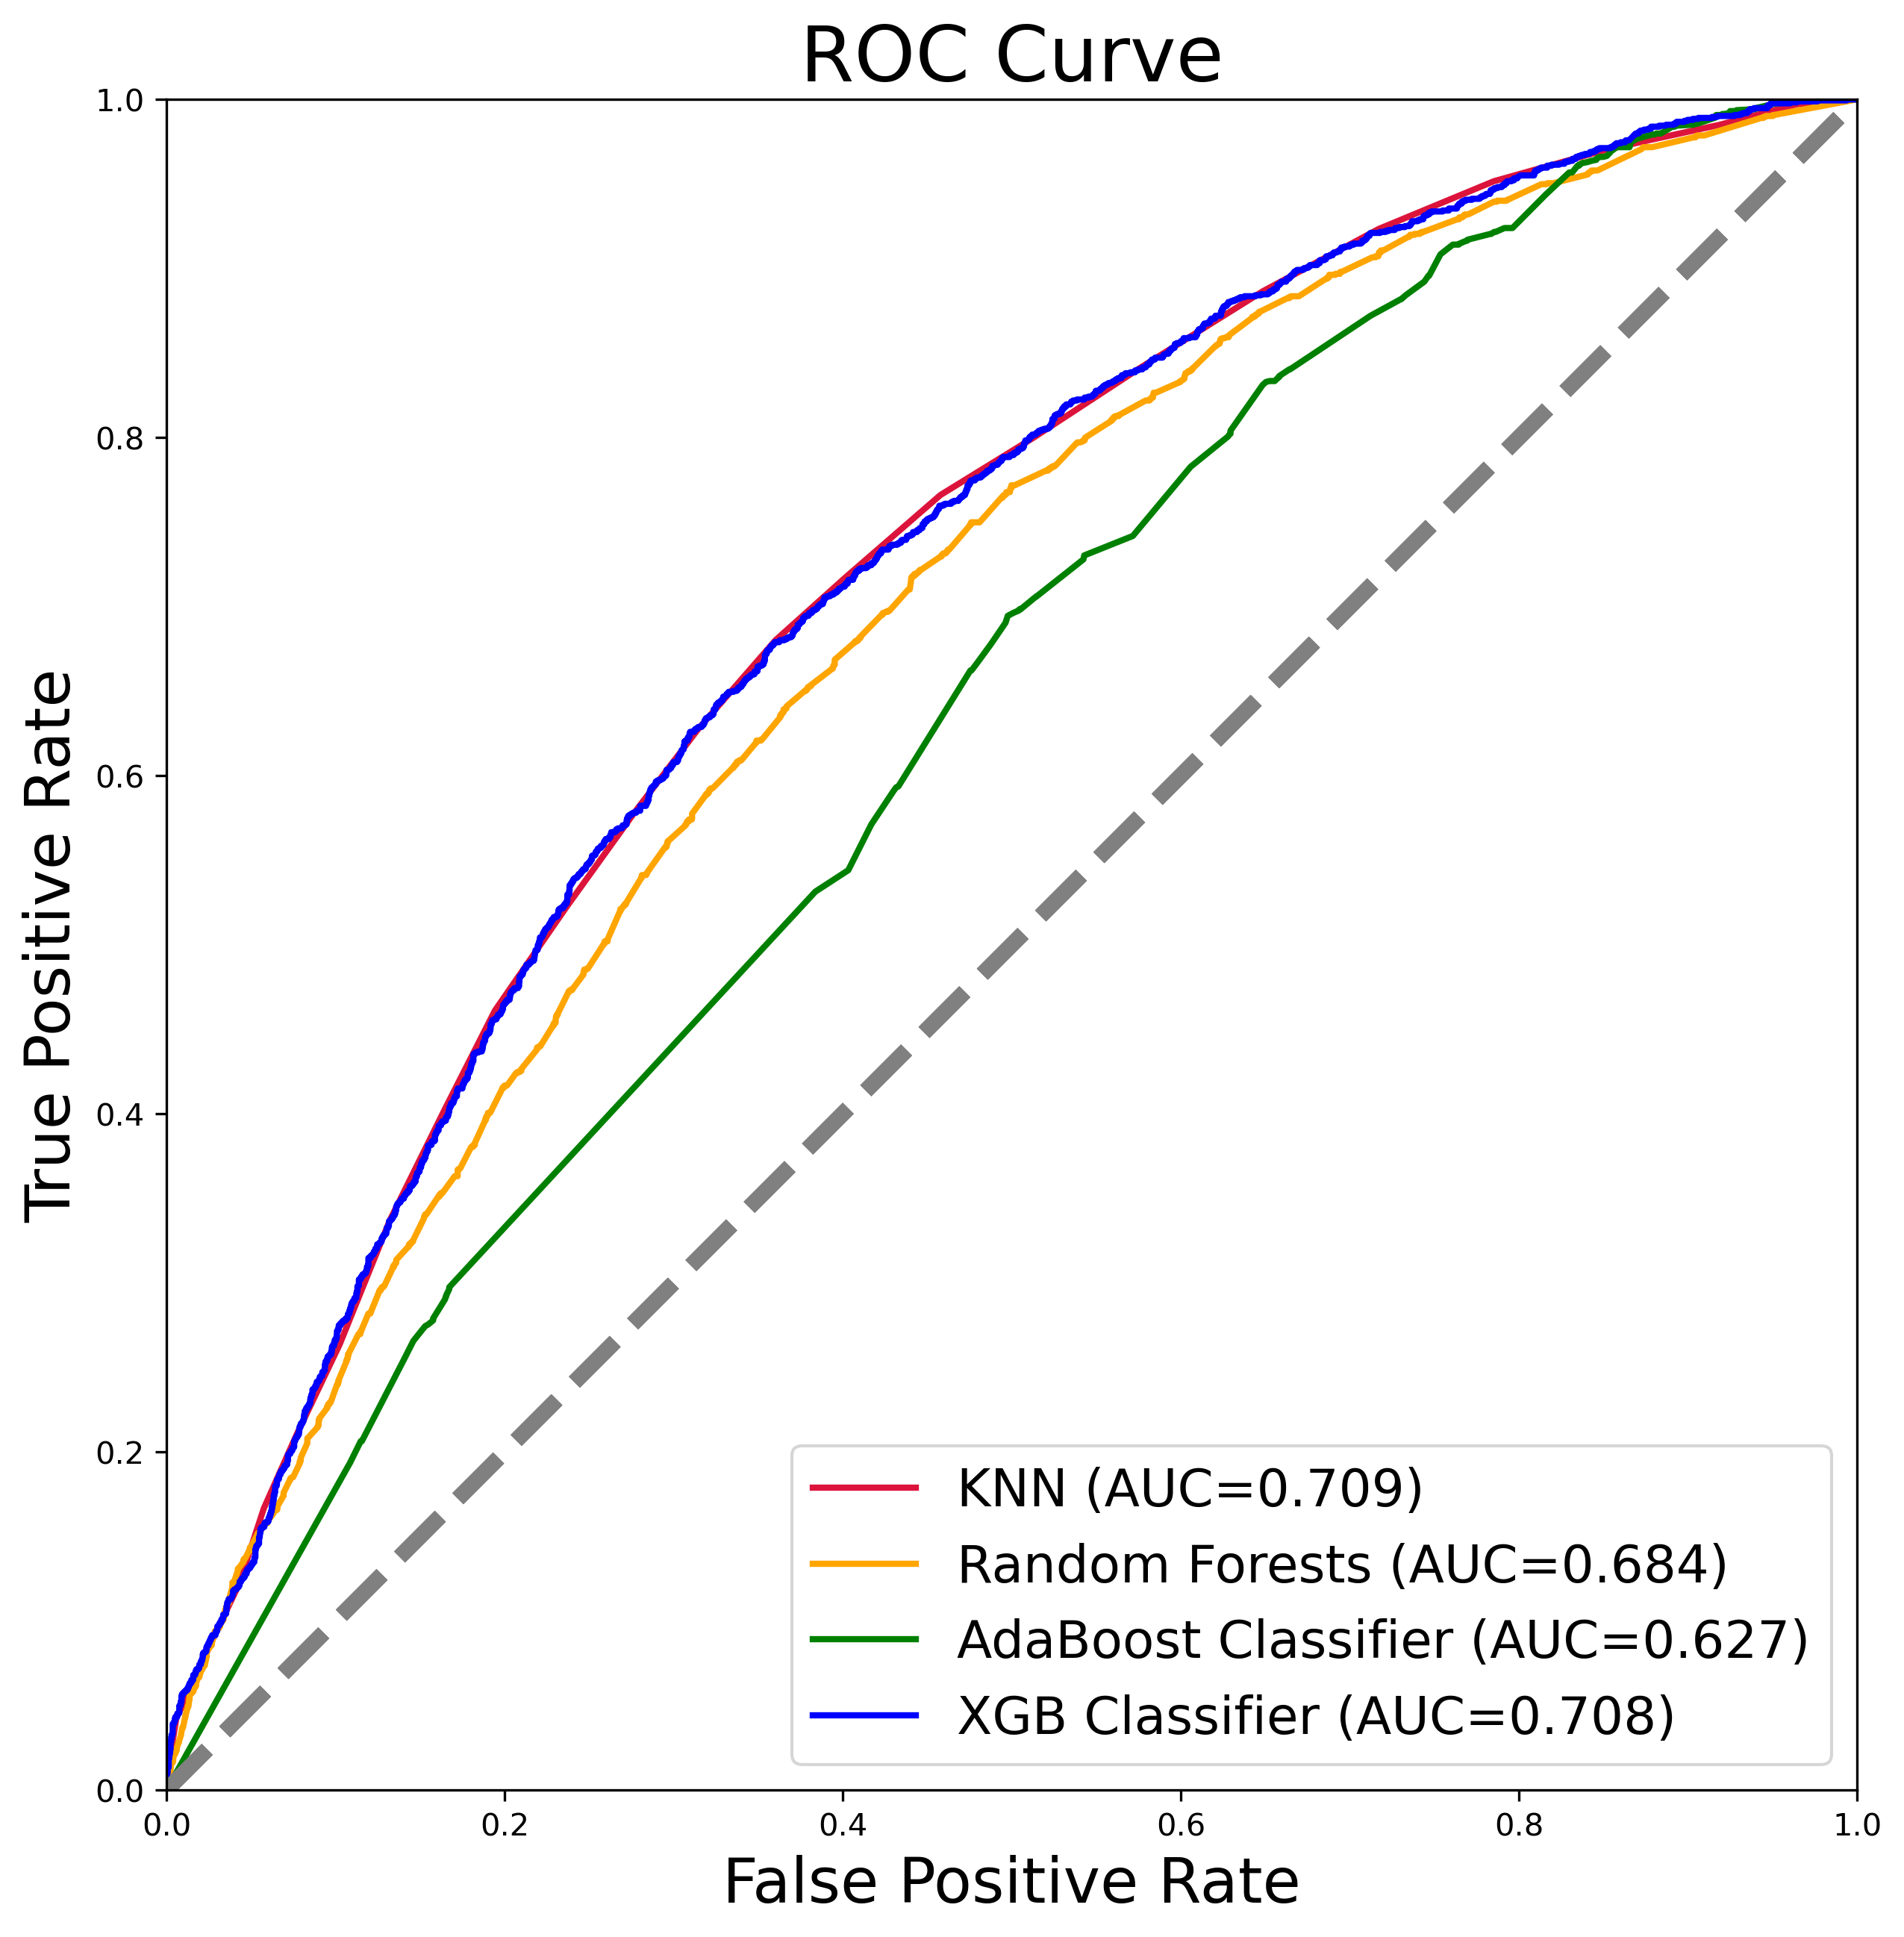

In [35]:
names = ['KNN','Random Forests','AdaBoost Classifier', 'XGB Classifier']

sampling_methods = [model_knn, model_random_forest, model_ada_boost, model_xgb]

colors = ['crimson', 'orange','green','blue', 'plum']

#ROC curves
test_roc_graph = multi_models_roc(names, sampling_methods, colors, x_test, y_test)

N=3

In [39]:
pca_3 = PCA(n_components=3)

x = pca_3.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2023, train_size=0.8)

scaler_x_train = preprocessing.StandardScaler().fit(x_train)

x_train = scaler_x_train.transform(x_train)

scaler_x_test = preprocessing.StandardScaler().fit(x_test)

x_test = scaler_x_test.transform(x_test)

K-Nearest Neighbors Algorithm with GridSearchCV

In [40]:
model_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid={'n_neighbors': range(2, 50)}, cv=10).fit(x_train, y_train)
print(model_knn.best_params_)
print('KNN, Training set score:', round(model_knn.score(x_train, y_train) * 100, 4))
print('KNN, Test set score:', round(model_knn.score(x_test, y_test) * 100, 4))

{'n_neighbors': 48}
KNN, Training set score: 62.7925
KNN, Test set score: 62.1834


Random Forest Classifier with HyperOpt

In [41]:
def hyperopt_rf_score(params):
    clf = RandomForestClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_rf = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(2,400)),
    'max_features': hp.choice('max_features', range(2,10))
}

best = fmin(fn=hyperopt_rf_score, space=space_rf, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6110133554940005                                                              
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 2}                     
0.5890650133208423                                                              
{'criterion': 'gini', 'max_depth': 75, 'max_features': 2}                       
nan                                                                             
{'criterion': 'entropy', 'max_depth': 370, 'max_features': 4}                   
nan                                                                             
{'criterion': 'entropy', 'max_depth': 345, 'max_features': 9}                   
0.5877274528773854                                                              
{'criterion': 'entropy', 'max_depth': 390, 'max_features': 3}                   
0.5921721836806613                                                              
{'criterion': 'entropy', 'max_depth': 34, 'max_features': 3}                    
nan                         

In [42]:
params = space_eval(space_rf, best)
params

{'criterion': 'entropy', 'max_depth': 390, 'max_features': 3}

In [43]:
model_random_forest = RandomForestClassifier(**params)
model_random_forest.fit(x_train, y_train)
model_random_forest.score(x_train, y_train)
print('Random Forest Classifier, Training set score:', round(model_random_forest.score(x_train, y_train) * 100, 4))
print('Random Forest Classifier, Test set score:', round(model_random_forest.score(x_test, y_test) * 100, 4))

Random Forest Classifier, Training set score: 96.8653
Random Forest Classifier, Test set score: 58.3451


AdaBoost Classifier

In [44]:
def hyperopt_ab_score(params):
    clf = AdaBoostClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_ab = {
    'n_estimators': hp.choice('n_estimators', range(50, 1000)),
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001)
}

best = fmin(fn=hyperopt_ab_score, space=space_ab, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.5797443221283152                                                              
{'learning_rate': 0.0043, 'n_estimators': 531}                                  
0.5812388677144925                                                              
{'learning_rate': 0.024200000000000003, 'n_estimators': 452}                    
0.5813567767367448                                                              
{'learning_rate': 0.0444, 'n_estimators': 775}                                  
0.5813568076758743                                                              
{'learning_rate': 0.044000000000000004, 'n_estimators': 367}                    
0.5811602049779203                                                              
{'learning_rate': 0.0137, 'n_estimators': 777}                                  
0.5814747940459501                                                              
{'learning_rate': 0.0369, 'n_estimators': 864}                                  
0.5810815267717834          

In [45]:
params = space_eval(space_ab, best)
params

{'learning_rate': 0.049800000000000004, 'n_estimators': 974}

In [46]:
model_ada_boost = AdaBoostClassifier(**params)
model_ada_boost.fit(x_train, y_train)
print('AdaBoost Classifier, Training set score:', round(model_ada_boost.score(x_train, y_train) * 100, 4))
print('AdaBoost Classifier, Test set score:', round(model_ada_boost.score(x_test, y_test) * 100, 4))

AdaBoost Classifier, Training set score: 58.1632
AdaBoost Classifier, Test set score: 58.8957


XGB Classifier with HyperOpt

In [47]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_xgb = {
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
    'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'exact'
}

best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6112096178615307                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.92, 'eta': 0.19, 'eval_metric': 'auc', 'gamma': 0.8300000000000001, 'learning_rate': 0.0175, 'max_depth': 5, 'min_child_weight': 4.95, 'n_estimators': 258, 'objective': 'binary:logistic', 'subsample': 0.995, 'tree_method': 'exact'}
0.6079055972907224                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.995, 'eta': 0.41500000000000004, 'eval_metric': 'auc', 'gamma': 0.8200000000000001, 'learning_rate': 0.049300000000000004, 'max_depth': 10, 'min_child_weight': 7.425000000000001, 'n_estimators': 331, 'objective': 'binary:logistic', 'subsample': 0.975, 'tree_method': 'exact'}
0.6107375331551446                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.855, 'eta': 0.395, 'eval_metric': 'auc', 'gamma': 0.645, 'learning_rate': 0.012400000000000001, 'max_depth': 11, 'min

In [48]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.5750000000000001,
 'eta': 0.045,
 'eval_metric': 'auc',
 'gamma': 0.675,
 'learning_rate': 0.0045000000000000005,
 'max_depth': 6,
 'min_child_weight': 5.825,
 'n_estimators': 628,
 'objective': 'binary:logistic',
 'subsample': 0.555,
 'tree_method': 'exact'}

In [49]:
model_xgb = XGBClassifier(**params)
model_xgb.fit(x_train, y_train)
print('XGB Classifier, Training set score:', round(model_xgb.score(x_train, y_train) * 100, 4))
print('XGB Classifier, Test set score:', round(model_xgb.score(x_test, y_test) * 100, 4))

XGB Classifier, Training set score: 59.4926
XGB Classifier, Test set score: 59.8553


ROC Curve

In [50]:
def multi_models_roc(names, sampling_methods, colors, x_test, y_test, save=False, dpin=300):

        plt.figure(figsize=(10, 10), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            
            y_test_preds = method.predict(x_test)
            y_test_predprob = method.predict_proba(x_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)

            plt.plot(fpr, tpr, lw=2, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=20)
            plt.ylabel('True Positive Rate',fontsize=20)
            plt.title('ROC Curve',fontsize=25)
            plt.legend(loc='lower right',fontsize =16.6)

        if save:
            plt.savefig('multi_models_roc.png')

        return plt

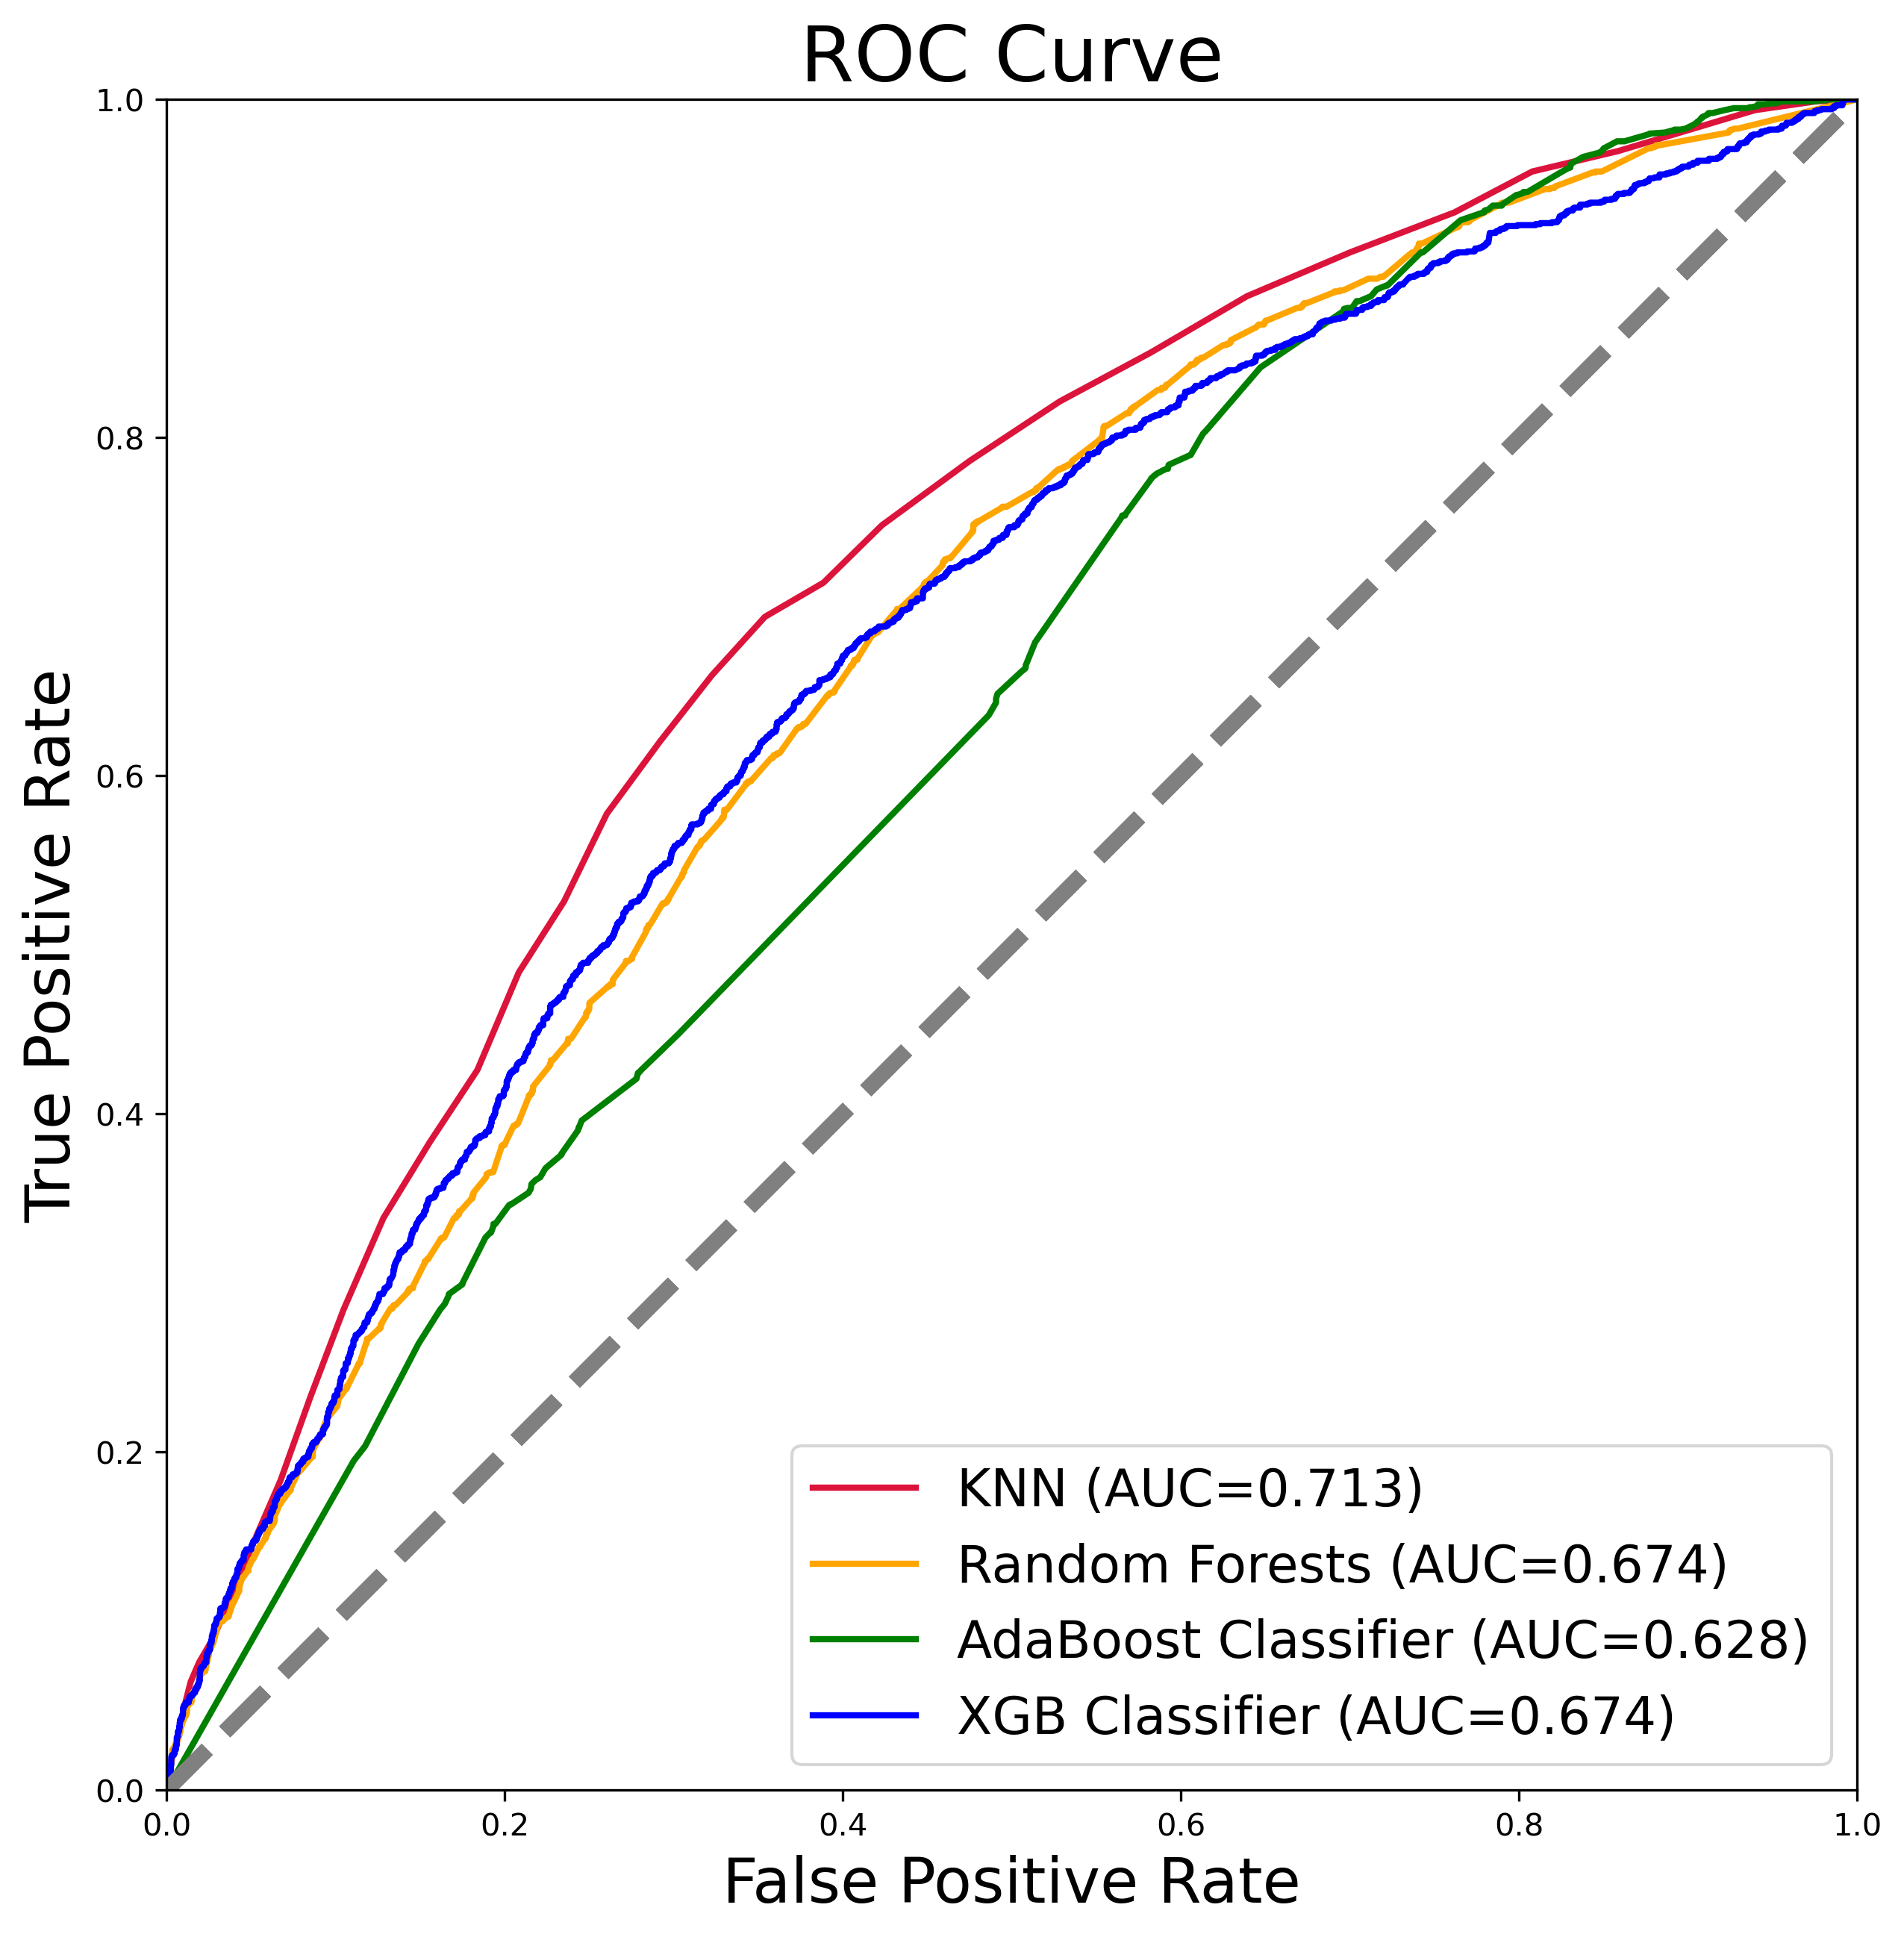

In [51]:
names = ['KNN','Random Forests','AdaBoost Classifier', 'XGB Classifier']

sampling_methods = [model_knn, model_random_forest, model_ada_boost, model_xgb]

colors = ['crimson', 'orange','green','blue', 'plum']

#ROC curves
test_roc_graph = multi_models_roc(names, sampling_methods, colors, x_test, y_test)